# COMPONENTS OF THIS PROJECT
### 1- Introduction

### 1- Data exploration

### 2- Convolutional neural networks

### 3- CNN model evaluation

# 1- Introduction:

In this competition, the goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. 10 digits are represented in this dataset [0 1 2 3 4 5 6 7 8 9 ]. We will try to preprocess the images and the labels and then feed the convolutional neural nets with those preprocessed images to classify them. The output will be the prediction of the digit represented in the image.

In [ ]:
#!pip install keras
!pip install tensorflow

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from keras.datasets import mnist
import keras.utils.np_utils as ku
import keras.models as models
import keras.layers as layers
from keras import regularizers
import numpy.random as nr

import keras
from keras.layers import Dropout
from keras.optimizers import rmsprop, Adam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.simplefilter(action='ignore')

%matplotlib inline
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


We start by opening our train and test datasets

In [3]:
#train=pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
#test=pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The table shows the 784 pixels of the pictures with the digits. We will need some preprocessing to reshape and scale the values.

> ## 1.1 Target and features


We set the target and the features:
* Target: Labels
* Features: train set without labels

In [4]:
target=train['label']
train.drop('label',axis=1, inplace=True)


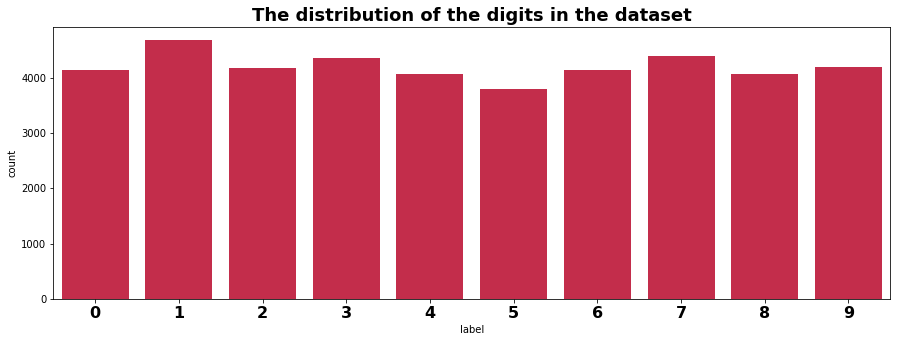

In [5]:
plt.figure(figsize=(15,5))
sns.countplot(target, color='crimson')
plt.title('The distribution of the digits in the dataset', weight='bold', fontsize='18')
plt.xticks(weight='bold', fontsize=16)
plt.show()

We have here the distribution of the digits in this dataset. They are all equally represented. We don't have any class imbalance here so we can go forward with our preprocessing.

> ### 1.2 Standardize the values

Models created with Keras, and most other deep learning frameworks, operate on floating point numbers. The gray scale pixel values of the images are coded as integers in the range  {0,255}

* These pixel values must be coerced to floating point and then standardized to be in a range  {0.0,1.0}

* As is the case for training many machine learning models, it is best to use standardized values for training deep neural networks.



In [6]:
train=train/255
test=test/255

In [7]:
Train=train.values.reshape(-1,28,28,1)
Test=test.values.reshape(-1,28,28,1)

> ### 1.3 Data visualization

Here is a glimpse of what we will be dealing with:

* Images of handwritten Digits from 0 to 9 
* We will feed those images to the CNN in order to learn and predict the test images.
* ** We have below an example of 60 digit images from this dataset**

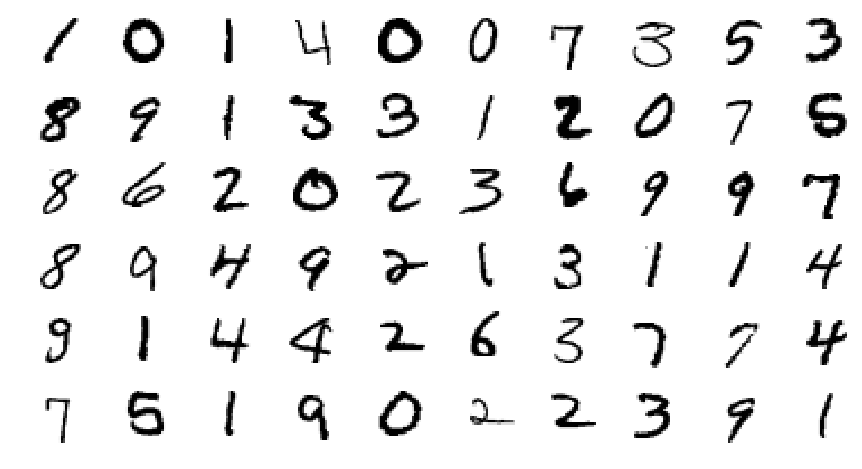

In [8]:
plt.figure(figsize=(15,8))
for i in range(60):
    plt.subplot(6,10,i+1)
    plt.imshow(Train[i].reshape((28,28)),cmap='binary')
    plt.axis("off")
plt.show()

> ### 1.4 Encoding target:

The labels are coded as integers corresponding to the digit in the image. We use One Hot Encoding to encode each label

In [9]:
Target=ku.to_categorical(target, num_classes=10)

In [10]:
print("The shape of the labels before One Hot Encoding",target.shape)
print("The shape of the labels after One Hot Encoding",Target.shape)
print("We have 10 columns for the 10 digits")

The shape of the labels before One Hot Encoding (42000,)
The shape of the labels after One Hot Encoding (42000, 10)
We have 10 columns for the 10 digits


In [11]:
print("Shape of the first image with label: '1' after OHE")
print(Target[0])

Shape of the first image with label: '1' after OHE
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


After reshaping the features and encoding the labels, we split them to train and test sets


> ### 1.5 Split: Train/Test

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(Train, Target, test_size=0.10, random_state=42)

In [14]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(37800, 28, 28, 1) (4200, 28, 28, 1) (37800, 10) (4200, 10)


# 2 Convolutional neural networks


> ## 2.1 Model parameters:
>### Regularization:

>> #### l2 Regularization
We will use l2 regularization, l2 regularization applies a penalty proportional to the l2 or Euclidean norm of the model weights to the loss function (Also called Ridge regression in sklearn).

> #### Dropout
We will also apply dropout regularization to train our CNN. We'll  define a neural network with a dropout layer with  𝑝=0.5 (Half of the nodes are dropped).

>### Activation functions
>>* The **ReLu** function:  rectilinear activation function is used for the hidden units.

>>* The **softmax** activation function is used for multi-class classifiers (Classification of 10 digits)

>### Padding
The coverage of the convolution opertor can be expanded by zero padding in the spatial dimenstion. With the zero padding added, the convolution operator covers the entire spatial dimension of the input tensor. 

>>* We add zero padding to convolutional layers with the parameter **padding = same**. It adds zero padding

>### CNN Architecture
* A multi-layer convolutional neural network to create a **feature map.**
> * **Con2D** is used to build feature maps from the data
> * **MaxPooling** is used to reduce dimensionality. In MaxPooling, the output value is just the maximum of the input values in each patch (for ex. The maximum pixel in a span of 3 pixels).
* A fully-connected hidden layer to perform the **classification.**
* An output layer to **identify the digits**.


> ## 2.1 Building the model:

> **1 CNN model: Without Batch normalization**

In [16]:
nn=models.Sequential()

In [17]:
## Add some convolutional layers to extract features = Feature map

nn.add(layers.Conv2D(16, (3, 3), padding = 'same', activation = 'relu', input_shape = (28, 28, 1)))
nn.add(layers.MaxPooling2D((2, 2)))
nn.add(layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (28, 28, 1)))
nn.add(layers.MaxPooling2D((2, 2)))
nn.add(layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
nn.add(layers.MaxPooling2D((2, 2)))
nn.add(layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
nn.add(layers.MaxPooling2D((2, 2)))
## latten the output of the convolutional layers so that fully connected network can be applied
nn.add(layers.Flatten())

## Finally, fully connected layers to classify the digits using the extracted features
nn.add(layers.Dense(64, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
nn.add(Dropout(0.5))
nn.add(layers.Dense(64, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
nn.add(Dropout(0.5))
nn.add(layers.Dense(10, activation = 'softmax'))

nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 64)         

> **2 CNN model: With Batch normalization**
* Batch normalization is used to increase the stability of a neural network, batch normalization normalizes the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation.
* It reduces overfitting because it has a slight regularization effects. Similar to dropout, it adds some noise to each hidden layer’s activations. 


In [18]:
## Add some convolutional layers to extract features = Feature map
nn1=models.Sequential()
nn1.add(layers.Conv2D(16, (3, 3), padding = 'same', activation = 'relu', input_shape = (28, 28, 1)))
nn1.add(BatchNormalization())
nn1.add(layers.MaxPooling2D((2, 2)))
nn1.add(layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (28, 28, 1)))
nn1.add(BatchNormalization())
nn1.add(layers.MaxPooling2D((2, 2)))
nn1.add(BatchNormalization())
nn1.add(layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
nn1.add(BatchNormalization())
nn1.add(layers.MaxPooling2D((2, 2)))

## latten the output of the convolutional layers so that fully connected network can be applied
nn1.add(layers.Flatten())

## Finally, fully connected layers to classify the digits using the extracted features
nn1.add(layers.Dense(64, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
nn1.add(Dropout(0.5))
nn1.add(layers.Dense(64, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
nn1.add(Dropout(0.5))
nn1.add(layers.Dense(10, activation = 'softmax'))

nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 64)         

### Optimization:

We will use **RMSprop**:
* RMSprop accumulates a measure of the squared gradient to change the learning rate. An exponential decay is applied to the accumulated squared gradient to ensure that more recent experience dominates the learning rate.



In [19]:
nn.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
nn1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

** Early stopping** terminates the training of the neural network model at an epoch before it becomes over-fit. We set the patience to epochs=5
 * The first callback, EarlyStopping, is for the early stopping method.
 * The second call back checkpoints or saves the current model.

In [21]:
filepath = 'my_model_file.hdf5' # define where the model is saved
callbacks_list = [
        keras.callbacks.EarlyStopping(
            monitor = 'val_loss', # Use accuracy to monitor the model
            patience = 5 # Stop after 5 steps with lower accuracy
        ),
        keras.callbacks.ModelCheckpoint(
            filepath = filepath, # file where the checkpoint is saved
            monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is worse
            save_best_only = True)]# Only save model if it is the best

>### 2.3 Data augmentation:

In order to avoid overfitting, we generate new images out of the existing images with some changes (rotation, zoom, width and height shift)

In [22]:
datagen = ImageDataGenerator(
        rotation_range=15,
        zoom_range = 0.15,
        width_shift_range=0.15,
        height_shift_range=0.15)
datagen.fit(x_train)

>### 2.4 Training the model:

In [23]:
history = nn.fit_generator(datagen.flow(x_train, y_train, batch_size=128),
                              epochs = 25, validation_data = (x_test,y_test),
                              steps_per_epoch=len(x_train) / 128, 
                              callbacks=callbacks_list)

Epoch 1/25
296/295 [==============================] - 45s 152ms/step - loss: 1.9437 - accuracy: 0.4492 - val_loss: 0.7425 - val_accuracy: 0.8574
Epoch 2/25
296/295 [==============================] - 44s 149ms/step - loss: 0.9015 - accuracy: 0.7831 - val_loss: 0.3594 - val_accuracy: 0.9521
Epoch 3/25
296/295 [==============================] - 44s 150ms/step - loss: 0.5989 - accuracy: 0.8769 - val_loss: 0.2565 - val_accuracy: 0.9693
Epoch 4/25
296/295 [==============================] - 44s 149ms/step - loss: 0.4519 - accuracy: 0.9129 - val_loss: 0.2338 - val_accuracy: 0.9674
Epoch 5/25
296/295 [==============================] - 44s 150ms/step - loss: 0.3682 - accuracy: 0.9312 - val_loss: 0.1990 - val_accuracy: 0.9712
Epoch 6/25
296/295 [==============================] - 44s 149ms/step - loss: 0.3177 - accuracy: 0.9407 - val_loss: 0.1552 - val_accuracy: 0.9800
Epoch 7/25
296/295 [==============================] - 44s 149ms/step - loss: 0.2804 - accuracy: 0.9493 - val_loss: 0.1504 - val_ac

> **(Check the output button for the training description)**

In [24]:
history2 = nn1.fit_generator(datagen.flow(x_train, y_train, batch_size=128),
                              epochs = 25, validation_data = (x_test,y_test),
                              steps_per_epoch=len(x_train) / 128, 
                              callbacks=callbacks_list)

Epoch 1/25
296/295 [==============================] - 73s 245ms/step - loss: 2.0822 - accuracy: 0.5495 - val_loss: 4.5677 - val_accuracy: 0.1219
Epoch 2/25
296/295 [==============================] - 76s 257ms/step - loss: 0.7008 - accuracy: 0.8806 - val_loss: 0.3660 - val_accuracy: 0.9571
Epoch 3/25
296/295 [==============================] - 77s 259ms/step - loss: 0.4381 - accuracy: 0.9277 - val_loss: 0.2176 - val_accuracy: 0.9793
Epoch 4/25
296/295 [==============================] - 76s 258ms/step - loss: 0.3373 - accuracy: 0.9447 - val_loss: 0.1578 - val_accuracy: 0.9862
Epoch 5/25
296/295 [==============================] - 74s 250ms/step - loss: 0.2815 - accuracy: 0.9533 - val_loss: 0.1431 - val_accuracy: 0.9879
Epoch 6/25
296/295 [==============================] - 74s 250ms/step - loss: 0.2629 - accuracy: 0.9568 - val_loss: 0.1467 - val_accuracy: 0.9838
Epoch 7/25
296/295 [==============================] - 73s 247ms/step - loss: 0.2412 - accuracy: 0.9595 - val_loss: 0.1554 - val_ac

**Early Stopping terminated the training at 29 epochs (Check the output of the cell above)**. The model reached 99% accuracy in the 27th epoch but didn't improve afterwards.

>### 2.5 Digits prediction

In [25]:
predicted = nn.predict(x_test)

In [26]:
predicted2 = nn1.predict(x_test)

# 3 CNN Model Evaluation

>### 3.1 Loss and accuracy

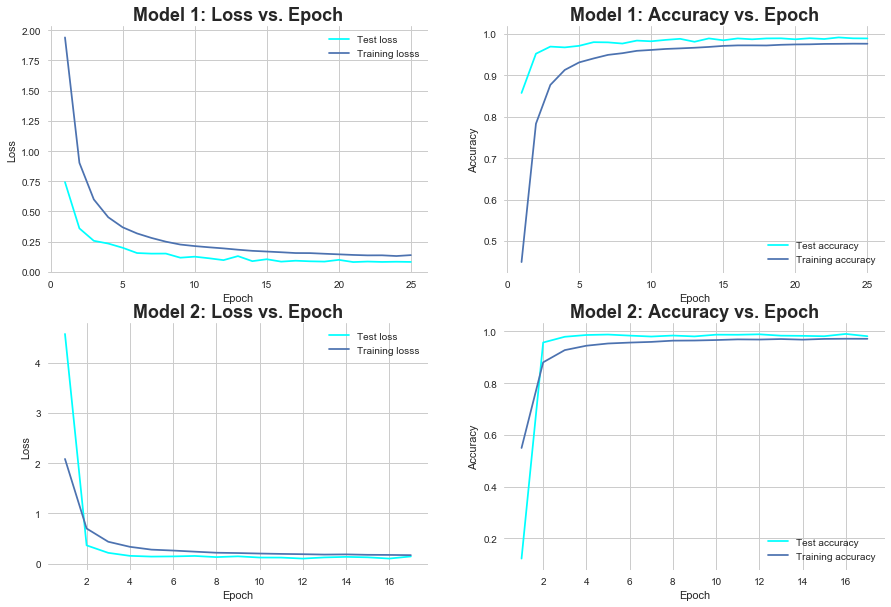

In [27]:
plt.style.use('seaborn')
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,10))
#First Model
ax1 = plt.subplot2grid((2,2),(0,0))
train_loss = history.history['loss']
test_loss = history.history['val_loss']
x = list(range(1, len(test_loss) + 1))
plt.plot(x, test_loss, color = 'cyan', label = 'Test loss')
plt.plot(x, train_loss, label = 'Training losss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 1: Loss vs. Epoch',weight='bold', fontsize=18)
ax1 = plt.subplot2grid((2,2),(0,1))
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
x = list(range(1, len(test_acc) + 1))
plt.plot(x, test_acc, color = 'cyan', label = 'Test accuracy')
plt.plot(x, train_acc, label = 'Training accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 1: Accuracy vs. Epoch', weight='bold', fontsize=18)  

#Second Model

ax1 = plt.subplot2grid((2,2),(1,0))
train_loss = history2.history['loss']
test_loss = history2.history['val_loss']
x = list(range(1, len(test_loss) + 1))
plt.plot(x, test_loss, color = 'cyan', label = 'Test loss')
plt.plot(x, train_loss, label = 'Training losss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 2: Loss vs. Epoch',weight='bold', fontsize=18)

ax1 = plt.subplot2grid((2,2),(1,1))
train_acc = history2.history['accuracy']
test_acc = history2.history['val_accuracy']
x = list(range(1, len(test_acc) + 1))
plt.plot(x, test_acc, color = 'cyan', label = 'Test accuracy')
plt.plot(x, train_acc, label = 'Training accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 2: Accuracy vs. Epoch', weight='bold', fontsize=18)  

plt.show()



* **Model 1**: The train/test accuracy and loss results look good. Our model didn't overfit.
* **Model 2**: Batch normalization reduced overfitting.
* Next, we check the confusion matrix to see the mistakes done by the classifier

>### 3.2 Confusion matrix

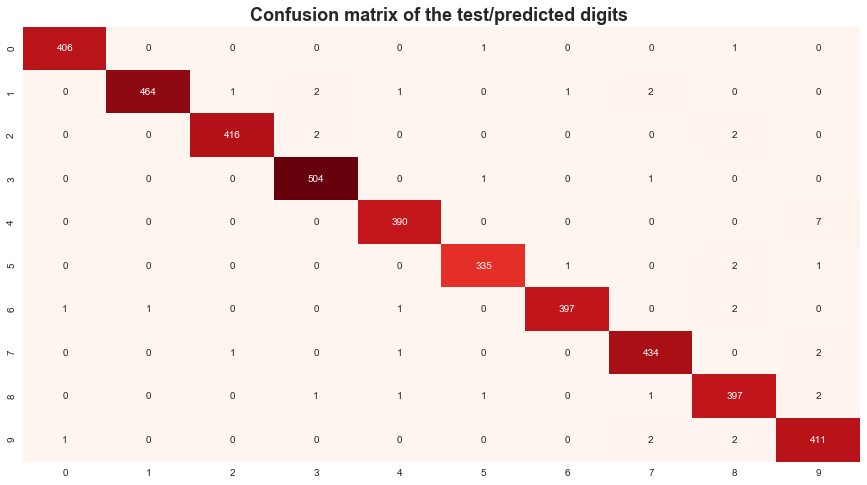

In [28]:
from sklearn.metrics import confusion_matrix

y_class = np.argmax(predicted, axis = 1) 

y_check = np.argmax(y_test, axis = 1) 

cmatrix = confusion_matrix(y_check, y_class)

plt.figure(figsize=(15,8))
plt.title('Confusion matrix of the test/predicted digits ', weight='bold', fontsize=18)
sns.heatmap(cmatrix,annot=True,cmap="Reds",fmt="d",cbar=False)


Good news! Just few misclassified digits, we can see that most of the mistakes are between digits that are kind of similar 

>### 3.3 Examples of misclassied digits:

* Here we have 36 misclassified digits:

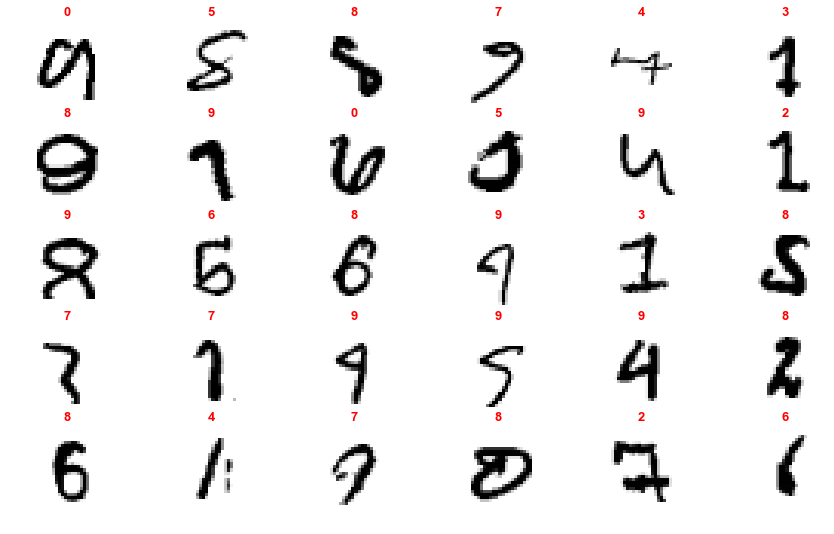

In [29]:
#We use np.argmax with y_test and predicted values: transform them from 10D vector to 1D
class_y = np.argmax(y_test,axis = 1) 
class_num=np.argmax(predicted, axis=1)
#Detect the errors
errors = (class_num - class_y != 0)
#Localize the error images
predicted_er = predicted[errors]
y_test_er = y_test[errors]
x_test_er = x_test[errors]

                
#Plot the misclassified numbers
plt.figure(figsize=(15,9))

for i in range(30):
    plt.subplot(5,6,i+1)
    plt.imshow(x_test_er[i].reshape((28,28)),cmap='binary')
    plt.title( np.argmax(predicted_er[i]), size=13, weight='bold', color='red')
    plt.axis("off")


plt.show()

We have the predicted values in red colors along with the misclassified images. What's interesting here is that the error is more from the humans than from the machine, some digits are written in an uncomprehensive way, it's difficult even for us to read some of these handwritings. I would have guessed the same as the machine in many of these cases.

* The digits shown in the section "**1.3 Data visualization**" are readable and clear in comparison to these misclassified digits. We plot them again in the figure below to notice the difference.

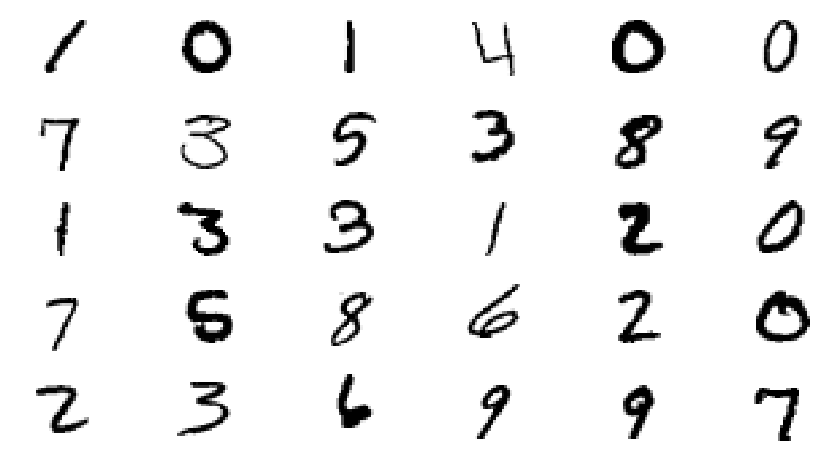

In [30]:
plt.figure(figsize=(15,8))

for i in range(30):
    plt.subplot(5,6,i+1)
    plt.imshow(Train[i].reshape((28,28)),cmap='binary')
    plt.axis("off")

plt.show()

Effectively, the misclassified digit are not clear in comparison with the rest of the digits. We reached a 99% accuracy and it could have been higher if the misclassified digits were written in a comprehensive way.

# 4 Submission

>Finally, we are done with our analysis. We fit the models on the test data


In [31]:
final = nn.predict(Test)
final = np.argmax(final,axis = 1)
final = pd.Series(final, name="Label")

>Create our CSV file and submit to competition

In [32]:
submission = pd.concat([pd.Series(range(1,len(Test)+1),name = "ImageId"),final],axis = 1)

submission.to_csv("CNN_digit_recognizer.csv", index=False)
